In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data

# Exploratory Data Analysis (EDA)

### Step 1: Let' s take a look at the data

In [3]:
df.sample(5)

,URL,Name
21140,https://raw.githubusercontent.com/tensorflow/t...,PYTHON
16287,https://raw.githubusercontent.com/nodejs/node/...,JAVASCRIPT
26439,https://raw.githubusercontent.com/ansible/ansi...,PYTHON
20898,https://raw.githubusercontent.com/tensorflow/t...,PYTHON
13223,https://raw.githubusercontent.com/elastic/elas...,JAVA


### Step 2: Number of Unique Values in all the columns

In [4]:
df.nunique()

URL     34720
Name       10
dtype: int64

In [5]:
df.describe()

,URL,Name
count,34723,34723
unique,34720,10
top,https://raw.githubusercontent.com/andrewhodel/...,PYTHON
freq,2,7393


### Step 3: Unique Values in 'Name Column' (Going to be made the target variable)

In [6]:
df['Name'].unique()

array(['G-CODE', 'GAP', 'GDSCRIPT', 'GO', 'JAVA', 'JAVASCRIPT', 'PHP',
       'PYTHON', 'RUBY', 'TYPESCRIPT'], dtype=object)

### Step 4: Duplicate Check for "URL" column (as this column should only have unique urls)

In [7]:
df['URL'].duplicated().sum()

3

### Step 5: Check the info() on the features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34723 entries, 0 to 34722
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     34723 non-null  object
 1   Name    34723 non-null  object
dtypes: object(2)
memory usage: 542.7+ KB


#### conclusion drawn from Step 5:
- both columns are of type 'object'

### Step 6: Check Class Distribution 

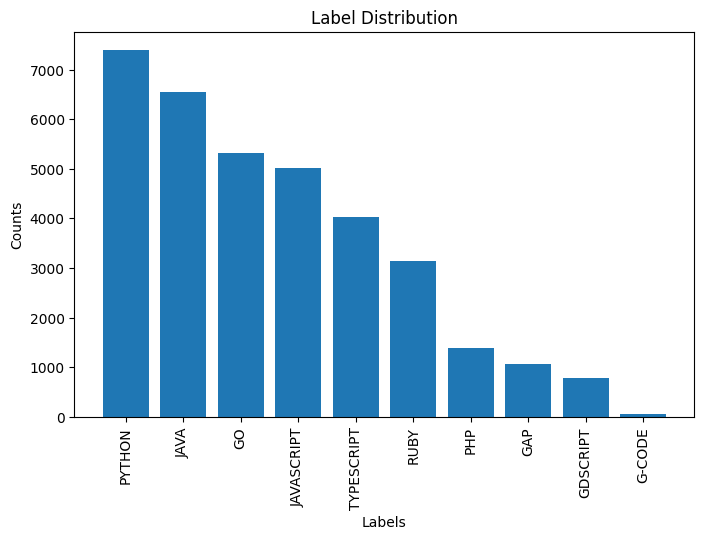

In [73]:
# Get the counts of unique labels within a column
label_counts = df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

# Custom Transformer classes (So that sklearn's pipeline can be used)

In [10]:
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
import chardet # an ML model, It uses machine learning to detect the encoding of a file


# Custom transformer to remove numbers from text
class NumberRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Remove numbers using regular expression
        return [re.sub(r'\d+', '', text) for text in X]
    
# Custom transformer to remove non-ASCII characters from the given text using a regular expression.
class NonASCIIRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # remove non-ASCII characters from the given text using a regular expression.
        return [re.sub(r'[^\x00-\x7F]+', '', text) for text in X]

# Custom transformer to remove multiple spaces from the content
class MultipleSpacesRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #  remove multiple spaces from the content
        return [" ".join(text.split()) for text in X]


class UrlToContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for url in X:
            while True:
                try:    
                    response = requests.get(url)
                    content = response.content
                    encoding = chardet.detect(content)
        
                    if encoding['encoding'] == "ISO-8859-1":
                        decoded_content = content.decode("iso-8859-1")
                    elif encoding['encoding'] == "GB2312":
                        decoded_content = content.decode("GB2312")
                    else:
                        decoded_content = content.decode("utf-8")

                    transformed_X.append(decoded_content)
                    break
                except Exception as e:
                    decoded_content = content.decode("utf-8")
                    transformed_X.append(decoded_content)
                    break
        return transformed_X


# Make Preprocessing Steps

In [11]:
from sklearn.pipeline import Pipeline

# Define the preprocessing steps
preprocessing_steps  = [
    ('url_to_content', UrlToContentTransformer()),
    ('non_ascii_removal', NonASCIIRemovalTransformer()),
    ('mutiple_space_removeal', MultipleSpacesRemovalTransformer()),
    ('number_removal', NumberRemovalTransformer()),
]

# Bag-of-Words (NLP technique)

In [12]:
# Bag-of-words can be implemented using "CountVectorizer" in sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Make a preprocessing Pipeline

In [13]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessing', Pipeline(steps=preprocessing_steps)),
    ('vectorizer', CountVectorizer(max_features=3000))
])

#### Apply the preprocessing pipeline to the dataset

In [14]:
df['Content'] = pipeline['preprocessing'].fit_transform(df['URL'])

#### Visualise the datset after the preprocessing pipeline

In [15]:
df['Content']

0        ; GL HV - by Wangibangi M G E M S M S G G Z F ...
1        ; G-Code generated by SimplifyD(R) Version .. ...
2        ; G-Code generated by SimplifyD(R) Version .. ...
3        ; G-Code generated by SimplifyD(R) Version .. ...
4        ; G-Code generated by SimplifyD(R) Version .. ...
                               ...                        
34718    /*--------------------------------------------...
34719    /*--------------------------------------------...
34720    /*--------------------------------------------...
34721    /*--------------------------------------------...
34722    /*--------------------------------------------...
Name: Content, Length: 34723, dtype: object

# Seperate the dataset into Independent and target variables

In [16]:
X = df['Content']
y = df['Name']

# Train-Test-Validation split

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into training set (80%) and temporary set (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation set (10%) and final training set (90%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

# Apply the Bag-of-Words

In [18]:
X_bow_train_vectorizer = pipeline['vectorizer'].fit(X_train)


X_bow_train = pipeline['vectorizer'].transform(X_train)
X_bow_val = pipeline['vectorizer'].transform(X_val)
X_bow_test = pipeline['vectorizer'].transform(X_test)

#### Note: We are preventing Data-Leakage form happening by seperating out train-test-validation splits before the vectorizer pipeline being applied to them. Also we are only fitting the vectorizer pipeline w.r.t to train data and no validation or test i sbeing utilised in this stage. Later we are using transform of pipeline to convert test and validation sets

# WordCloud Analysis for Classes

In [33]:
from wordcloud import WordCloud


# Get the unique class labels from y_train
unique_classes = np.unique(y_train)

feature_names = pipeline['vectorizer'].get_feature_names_out()

# Define a dictionary to store the BoW data for each class
class_bow_data = {label: {feature_names[j]: 0 for j in range(X_bow_train.shape[1])} for label in unique_classes}

# Initialize an empty dictionary to store the combined data
combined_data = {}


# Group the BoW data based on class labels
for label1 in unique_classes:
    for index, label2 in enumerate(y_train):
        # Get the i-th document's word frequencies
        word_frequencies = {feature_names[j]: X_bow_train[index, j] for j in range(X_bow_train.shape[1])}
        # Iterate through the list of dictionaries
        if label1 == label2:
            for key, value in word_frequencies.items():
                if key in combined_data:
                    combined_data[key] += value
                else:
                    combined_data[key] = value
            class_bow_data[label1] = combined_data


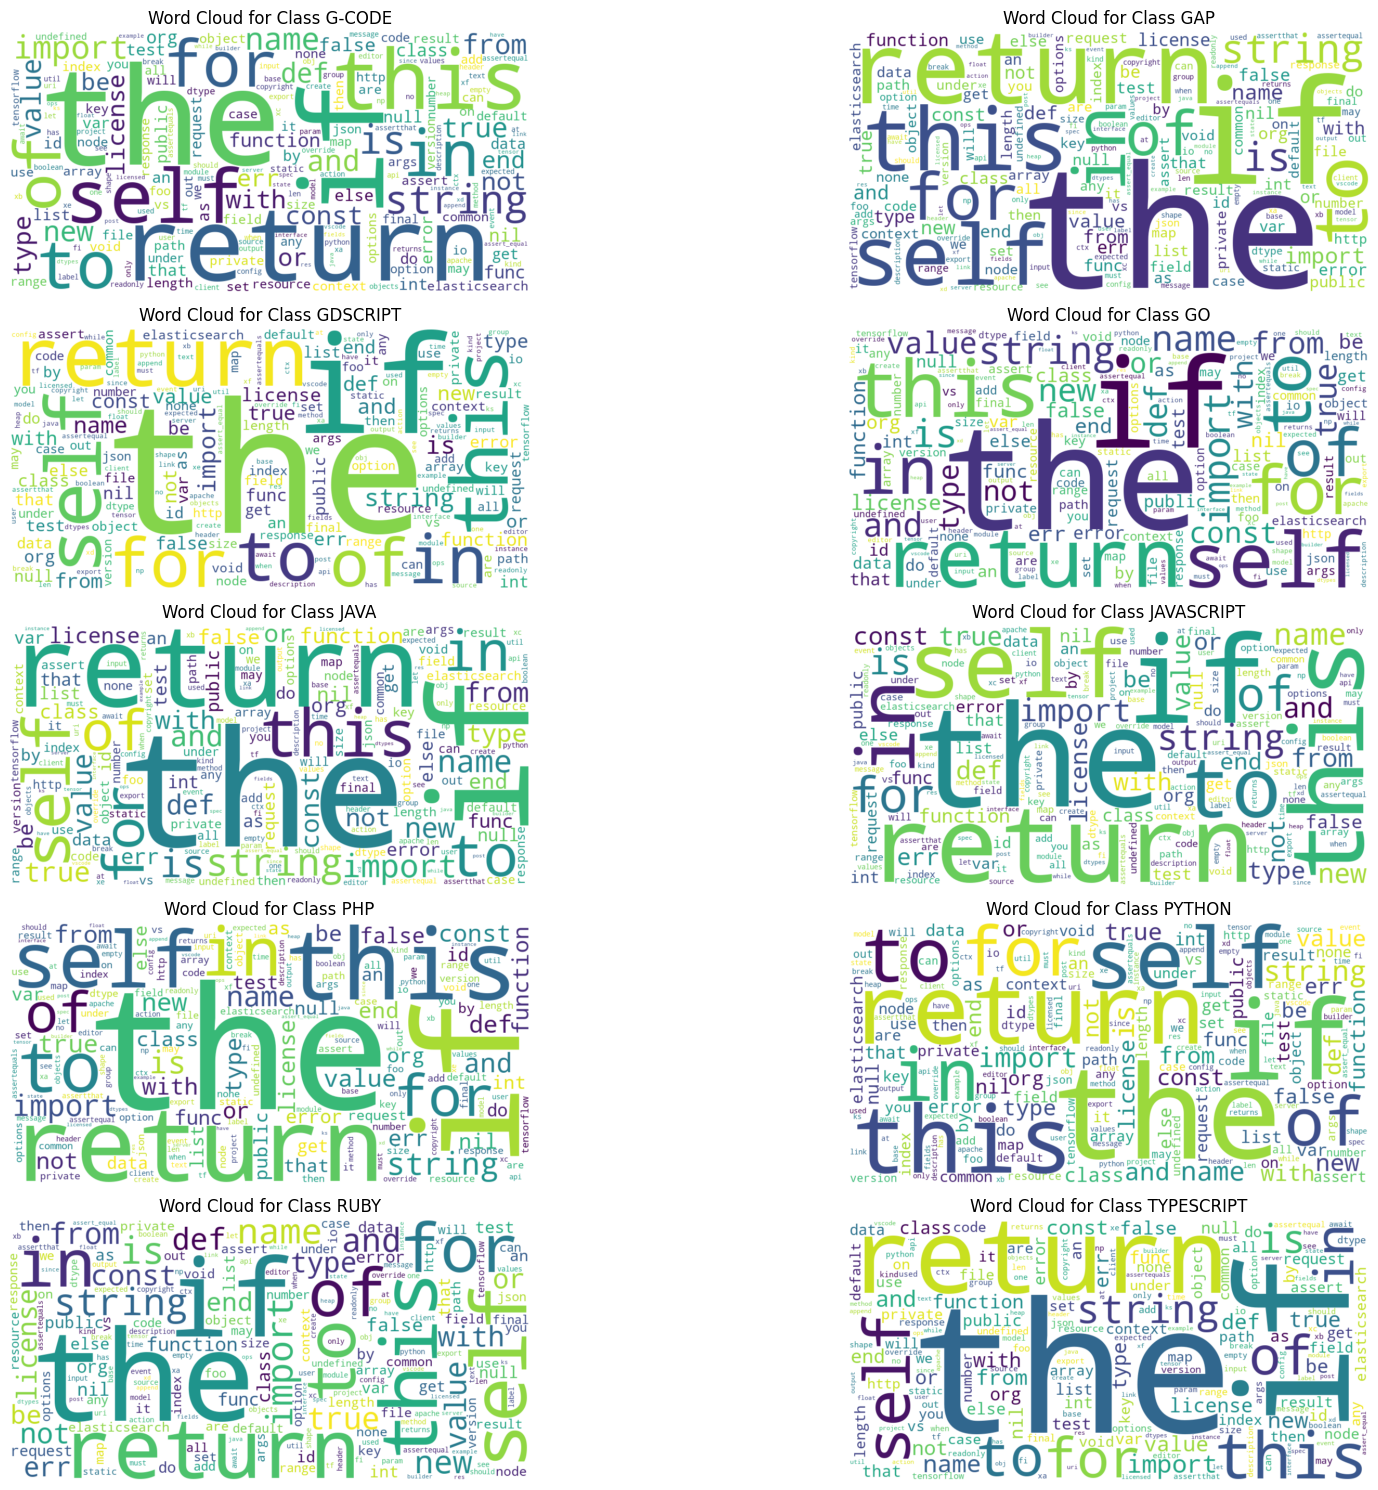

In [46]:
# Generate Word Clouds
wordcloud = WordCloud(width=1000, height=500, background_color='white')

# Calculate the number of unique classes
num_classes = len(unique_classes)

# Create subplots with two columns
num_cols = 2
num_rows = (num_classes + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Flatten the axes if needed
if num_rows > 1:
    axes = axes.flatten()

# Iterate over unique classes and create word clouds
for idx, label in enumerate(unique_classes):
    # Combine all BoW vectors for the current class
    word_frequencies = class_bow_data[label]

    # Plot the word cloud in the appropriate subplot
    ax = axes[idx]
    wordcloud.generate_from_frequencies(word_frequencies)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for Class {label}')
    ax.axis('off')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

#### check the length of the feature vectors

In [47]:
len( pipeline['vectorizer'].get_feature_names_out()) 

3000

#### Display the feature vectors

In [48]:
pipeline['vectorizer'].get_feature_names_out()

array(['__', '__class__', '__future__', ..., 'zip', 'zone', 'zones'],
      dtype=object)

# Classifiers (Have more classifiers here and use RandomSearchCV for hyperparameter tuning)

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced') 

#### NOTE: class_weight='balanced' because as seen in evaluation GAP files are lower in comparison to the other programmming languages

# Cross-Validation

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Specify the number of folds
num_folds = 5

accuracy_scores = cross_val_score(clf, X_bow_train, y_train, cv=num_folds, scoring=make_scorer(f1_score, average='weighted'))
print(np.mean(accuracy_scores))

0.9896571699302619


# Train the Model

In [60]:
clf.fit(X_bow_train, y_train)

RandomForestClassifier(class_weight='balanced')

# Evaluate the model

### Prection on test data

In [61]:
y_pred = clf.predict(X_bow_test)

### Step 1: Accuracy

In [62]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9959683225341973


### Step 2: Precision

In [63]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='weighted')
print(precision)

0.9959758029699184


### Step 3: Recall

In [64]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='weighted')
print(recall)

0.9959683225341973


### Step 4: F1-score

In [65]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9959505862829108


### Step 5: Classfication Report (Summary of steps 1-4)

In [66]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      G-CODE       1.00      0.80      0.89        10
         GAP       0.99      0.98      0.99       199
    GDSCRIPT       0.99      1.00      1.00       155
          GO       1.00      1.00      1.00      1082
        JAVA       0.99      1.00      1.00      1322
  JAVASCRIPT       0.99      0.99      0.99       986
         PHP       1.00      1.00      1.00       294
      PYTHON       0.99      1.00      1.00      1455
        RUBY       1.00      1.00      1.00       643
  TYPESCRIPT       1.00      0.99      1.00       799

    accuracy                           1.00      6945
   macro avg       1.00      0.98      0.99      6945
weighted avg       1.00      1.00      1.00      6945



### Step 6: Confusion Matrix

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

#### Plot Confusion Matrix

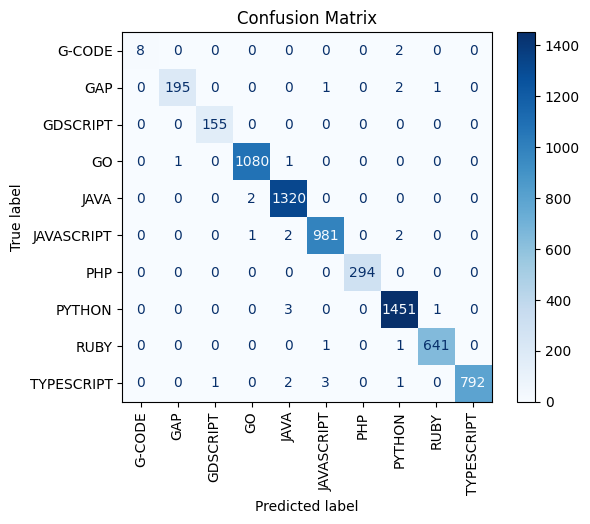

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

# Save the model

In [69]:
import os

print(os.getcwd())
print(os.path.dirname(os.getcwd()))

C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks
C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub


In [70]:
import pickle

# Full pipeline with preprocessing and classifier
full_pipeline = Pipeline([
    ('full_preprocessing', pipeline),
    ('classifier', clf)
])

# Save the full_pipeline object
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
os.makedirs(clf_folder_path, exist_ok=True)
clf_file_path = os.path.join(clf_folder_path, 'classifier1.pkl')

with open(clf_file_path, 'wb') as f:
    pickle.dump(full_pipeline, f)


# Load the saved model and see whether working or not

In [71]:
import joblib

# Load the saved pipeline
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
clf_file_path = os.path.join(clf_folder_path, 'classifier1.pkl')
loaded_pipeline = joblib.load(clf_file_path)

# Use the loaded pipeline for predictions or other operations
predictions = loaded_pipeline.predict(['https://raw.githubusercontent.com/opencv/opencv/3aeaa3402389fc55e53fbc6f5741ca29f51032ee/modules/core/misc/java/src/java/core%2BMat.java'])

In [72]:
predictions

array(['JAVASCRIPT'], dtype=object)